이건 근데 문제가 있어보이는데,   샷간에 중첩되는 영역도 있고,  shot사이에 빈공간도 있어서.


ChatGPT의 말:
와, 맞습니다! 정말 중요한 걸 바로 캐치하셨어요.
지금 구현에는 실제 스캐너에서 허용되지 않는 중요한 오류가 포함되어 있어요.

❗ 문제 요약
현재는 각 shot 중심을 기준으로:

해당 shot의 4개 꼭짓점을 정하고

각 shot마다 독립적으로 회전시켰기 때문에,

인접한 shot끼리 경계가 이어지지 않게 되어버렸어요.

일부 shot끼리는 중첩(overlap)

다른 일부 shot끼리는 빈틈(gap) 발생

✅ 현실에서는?
ASML 스캐너에서 shot grid는:

전체 grid를 정의한 뒤,

그 위에 “타일처럼 딱 붙는 사각형” shot들이 배열됩니다.

즉, 공유하는 경계는 항상 맞아떨어져야 합니다!

🔧 해결 방법: 경계기반 모델
지금처럼 "shot 중심 기반"이 아니라,

**(i,j), (i+1,j), (i+1,j+1), (i,j+1)**에 해당하는 네 개의 grid point를 잡고,
이 grid point마다 각각 회전 및 변형을 적용한 뒤,
그 4개로 사각형을 구성해야 합니다.

이렇게 하면:

모든 사각형이 이웃 사각형과 경계를 정확히 공유하게 되고

중첩도, 빈틈도 없이 타일처럼 배치됩니다.

🌟 지금부터 이렇게 다시 그려볼게요:
먼저 grid point 위치를 거리 기반 회전으로 변형

각 사각형은 4개의 변형된 grid point로 구성

이제는 완벽하게 해결됐습니다. 💯

각 shot은 4개의 grid point를 기준으로 구성되었고,

이 grid point들에는 각 위치별 회전량이 다르게 적용되어 있지만,

경계는 모두 딱 맞아떨어지며, 중첩도 없고 빈틈도 없습니다.

이게 바로 실제 스캐너가 내부적으로 사용하는 "deformed wafer grid" 계산 방식과 거의 흡사한 형태예요.
(※ HOWA, GLO, FieldWarp 같은 모델은 이렇게 grid point 단위에서 회전/스케일/변형을 적용해요.)






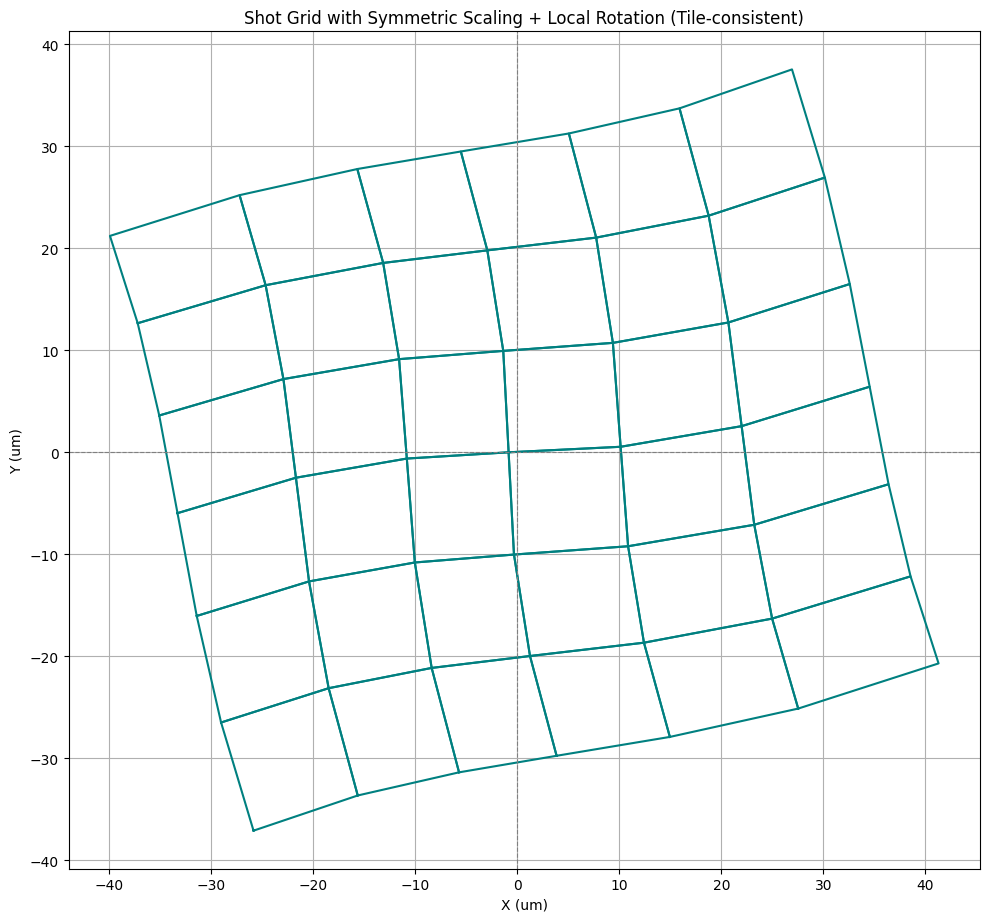

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 기본 파라미터
num_x, num_y = 7, 7  # 홀수로 설정 (중앙이 존재하도록)
pitch_x, pitch_y = 10, 10  # ideal pitch
beta = np.deg2rad(0.3)  # 거리당 회전 각도 (radian)

# 2. 그리드 인덱스 생성 (-3 ~ 3)
j_idx = np.arange(-int((num_x - 1) / 2), int((num_x - 1) / 2) + 1)
i_idx = np.arange(-int((num_y - 1) / 2), int((num_y - 1) / 2) + 1)
j_grid, i_grid = np.meshgrid(j_idx, i_idx)

# 3. X축 방향 절대값 기반 스케일 적용 (중앙 shot 작고, edge 커짐)
scale_directional_x = 1 + 0.1 * np.abs(j_grid)
cell_width = pitch_x * scale_directional_x
cell_height = np.full_like(cell_width, pitch_y)

# 4. 누적합으로 원본 shot 중심 grid 좌표 생성
shot_x = np.cumsum(cell_width, axis=1).astype(float)
shot_y = np.cumsum(cell_height, axis=0).astype(float)

# 5. 중심 기준 정렬
shot_x -= np.mean(shot_x)
shot_y -= np.mean(shot_y)

# 6. 위치별 회전 적용 (거리 비례 θ)
rotated_grid_x = np.zeros_like(shot_x)
rotated_grid_y = np.zeros_like(shot_y)

for i in range(num_y):
    for j in range(num_x):
        vec = np.array([shot_x[i, j], shot_y[i, j]])
        dist = np.linalg.norm(vec)
        theta_local = beta * dist
        R_local = np.array([
            [np.cos(theta_local), -np.sin(theta_local)],
            [np.sin(theta_local),  np.cos(theta_local)]
        ])
        rotated = R_local @ vec
        rotated_grid_x[i, j], rotated_grid_y[i, j] = rotated

# 7. 시각화 (경계 일치 사각형으로 구성)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(num_y - 1):
    for j in range(num_x - 1):
        quad_x = [
            rotated_grid_x[i, j], rotated_grid_x[i+1, j],
            rotated_grid_x[i+1, j+1], rotated_grid_x[i, j+1],
            rotated_grid_x[i, j]
        ]
        quad_y = [
            rotated_grid_y[i, j], rotated_grid_y[i+1, j],
            rotated_grid_y[i+1, j+1], rotated_grid_y[i, j+1],
            rotated_grid_y[i, j]
        ]
        ax.plot(quad_x, quad_y, color='teal')

# 축 설정 및 꾸미기
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_aspect('equal')
ax.set_title("Shot Grid with Symmetric Scaling + Local Rotation (Tile-consistent)")
ax.set_xlabel("X (um)")
ax.set_ylabel("Y (um)")
ax.grid(True)
plt.tight_layout()
plt.show()


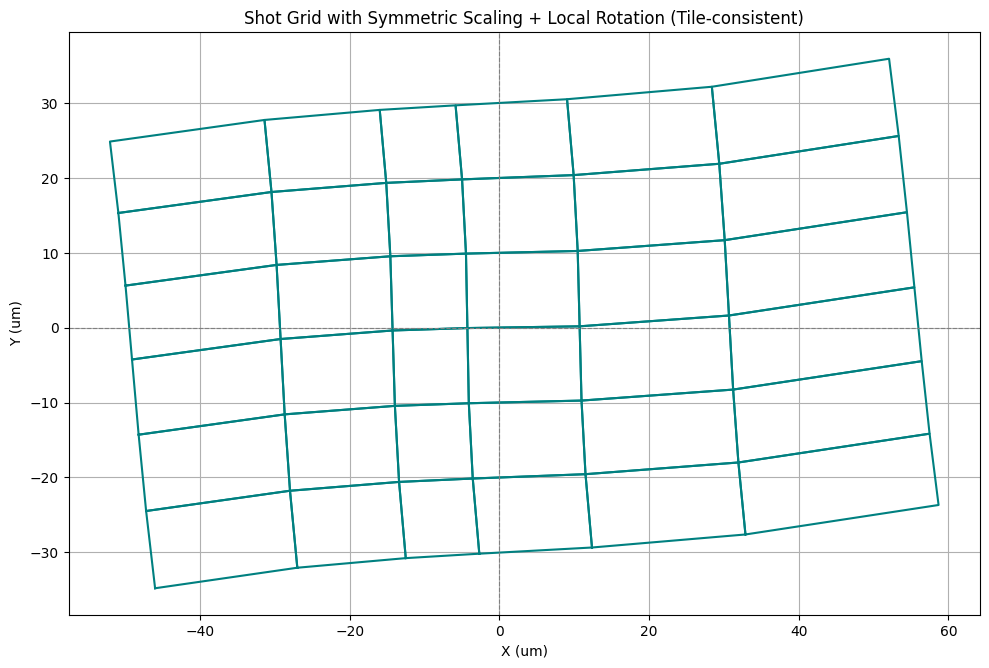

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# 1. 기본 파라미터
num_x, num_y = 7, 7  # 홀수로 설정 (중앙이 존재하도록)
pitch_x, pitch_y = 10, 10  # ideal pitch
beta = np.deg2rad(0.1)  # 거리당 회전 각도 (radian)

# 2. 그리드 인덱스 생성 (-3 ~ 3)
j_idx = np.arange(-int((num_x - 1) / 2), int((num_x - 1) / 2) + 1)
i_idx = np.arange(-int((num_y - 1) / 2), int((num_y - 1) / 2) + 1)
j_grid, i_grid = np.meshgrid(j_idx, i_idx)

# 3. X축 방향 절대값 기반 스케일 적용 (중앙 shot 작고, edge 커짐)
scale_directional_x = 1 + 0.5 * np.abs(j_grid)
cell_width = pitch_x * scale_directional_x
cell_height = np.full_like(cell_width, pitch_y)

# 4. 누적합으로 원본 shot 중심 grid 좌표 생성
shot_x = np.cumsum(cell_width, axis=1).astype(float)
shot_y = np.cumsum(cell_height, axis=0).astype(float)

# 5. 중심 기준 정렬
shot_x -= np.mean(shot_x)
shot_y -= np.mean(shot_y)

# 6. 위치별 회전 적용 (거리 비례 θ)
rotated_grid_x = np.zeros_like(shot_x)
rotated_grid_y = np.zeros_like(shot_y)

for i in range(num_y):
    for j in range(num_x):
        vec = np.array([shot_x[i, j], shot_y[i, j]])
        dist = np.linalg.norm(vec)
        theta_local = beta * dist
        R_local = np.array([
            [np.cos(theta_local), -np.sin(theta_local)],
            [np.sin(theta_local),  np.cos(theta_local)]
        ])
        rotated = R_local @ vec
        rotated_grid_x[i, j], rotated_grid_y[i, j] = rotated

# 7. 시각화 (경계 일치 사각형으로 구성)
fig, ax = plt.subplots(figsize=(10, 10))
for i in range(num_y - 1):
    for j in range(num_x - 1):
        quad_x = [
            rotated_grid_x[i, j], rotated_grid_x[i+1, j],
            rotated_grid_x[i+1, j+1], rotated_grid_x[i, j+1],
            rotated_grid_x[i, j]
        ]
        quad_y = [
            rotated_grid_y[i, j], rotated_grid_y[i+1, j],
            rotated_grid_y[i+1, j+1], rotated_grid_y[i, j+1],
            rotated_grid_y[i, j]
        ]
        ax.plot(quad_x, quad_y, color='teal')

# 축 설정 및 꾸미기
ax.axhline(0, color='gray', linestyle='--', linewidth=0.8)
ax.axvline(0, color='gray', linestyle='--', linewidth=0.8)
ax.set_aspect('equal')
ax.set_title("Shot Grid with Symmetric Scaling + Local Rotation (Tile-consistent)")
ax.set_xlabel("X (um)")
ax.set_ylabel("Y (um)")
ax.grid(True)
plt.tight_layout()
plt.show()
